## Deep Learning and Probabilistic Models

The objective of *discriminative models* is to output an estimate of the class conditional probabilities for given inputs. 

To see why, let's restate Bayes rule for a given input:

$$ 
p(y \vert x) = \frac{p(x \vert y) p(y)}{p(x)} = \frac{p(x,y)}{p(x)}
$$

Discriminative classifiers jump directly to estimating $p(y \vert x)$ without modeling its component parts $p(x,y)$ and $p(x)$.

The objective of *generative models* is to learn a model $p(x)$. This model can be used for several purposes, but we are specially interested in models we can sample from. 

To this end we have several possible strategies when considering deep learning tools:

+ **Fully-observed models.** To model observed data directly, without introducing any new unobserved local variables.

+ **Transformation models.** Model data as a transformation of an unobserved noise source using a *parameterised* function.

+ **Latent-variable models.** Introduce unobserved random variables for every observed data point to explain hidden causes.

### Fully-observed models.

The most succesful models are PixelCNN (https://arxiv.org/pdf/1606.05328v2.pdf) and WaveNet (https://arxiv.org/pdf/1609.03499.pdf)).

Both cases are based on autoregressive models that models the conditional distribution of every individual data feature (pixels,etc.) given previous features:

$$
p(\mathbf x) = \prod_{i=1}^{N} p(x_i \vert x_1, \dots ,x_{i-1})
$$

PixelCNN predict pixels sequentially rather than predicting the whole image at once. All conditional probabilities are described by deep networks.

Its advantages are:

+ Parameter learning is simple: Log-likelihood is directly computable, no approximation needed.
+ Easy to scale-up to large models, many optimisation tools available.

But generation can be slow: we must iterate through all elements sequentially!

### Transformation Models

Transformation models model $p(x,z)$ instead of $p(x)$, where $z$ is an unobserved noise source. 

In the simplest case, they transform an unobserved noise source $z \sim \mathcal{N}(0,I)$ using a parameterised function. The transformation function is parameterised by a linear or deep network $f_\lambda(z)$. 

For example, for producing $x \sim \mathcal{N}(\mu, \Sigma)$ we can sample $z \sim \mathcal{N}(0,I)$ and then apply $x = \mu + \Sigma z$.

The main drawbacks of this strategy are the difficulty to extend to generic data types and the difficulty to account for noise in observed data.

### Latent variable models 

Latent variable models solve this problems by introducing unobserved
local random variables that represents *hidden causes* and which can be easily sampled. 

Variational autoencoders are a good example of this strategy that propose a specific probability model of data $x$ and latent variables $z$. 

## Variational Autoencoders Recap

We are aiming to maximize the probability of each $x$ in the dataset according to 

$$p(x) = \int p(x \vert z) p(z) dz$$

In VAE $p(x \vert z)$ can be defined to be Bernoulli or to be Gaussian, i.e. $p(x \vert z) = \mathcal{N}(f(z), \sigma^2 \times I)$ where $f$ is a deterministic function parametrized by $\lambda$. Then, our objective is to find the best parameters to represent $p(x)$, i.e. to maximize this integral with respect to $\lambda$.

Given $f$, the generative process can be written as follows. For each datapoint $i$:

+ Draw latent variables $z_i \sim p(z)$. 
+ Draw datapoint $x_i \sim p(x\vert z)$

To solve our  problem we must deal with:

+ how to define the latent variables $z$.
+ how to deal with the integral.

Regarding $z$, VAE assume that there are no easy interpretations of the dimensions of $z$ and chooses a simple distribution from which samples can be easily drawn: $\mathcal{N}(0,I)$.  

>This choice is based on the well-known fact that any distribution in $d$ dimensions can be generated by taking a set of $d$ variables that are normally distributed and mapping them through a sufficient complicated function. 

Now all that remains is to optimize the integral, where $p(z) = \mathcal{N}(0,I)$.

If we can find a computable formula for $p(x)$ and we can take the gradient of the formula, then we can optimize the model.

The naive approach for computing an approximate $p(x)$ is straighforward: we can sample a large number of $z$ values and compute $p(x) \approx \frac{1}{n} \sum_i p(x \vert z_i)$. But if we are dealing with a high dimensional space, this option is not feasible. 

Is there a shortcut we can take when using sampling to compute the integral?

The key idea in VAE is to attempt to sample values of $z$ that are likely to have produced 
$x$. This means we need a new function $q(z \vert x)$ which can take a value of $x$ and give us a distribution over $z$ values that are likely to produce $x$.


Let's consider the (similarity) KL divergence between some arbitrary $q_\lambda (z \vert x)$ and $p(z \vert x)$.

$$ KL(q_\lambda(z \vert x) \| p(z \vert x)) = \sum_z p(z) \mathop{{}log} \frac{q_\lambda(z \vert x)}{p(z \vert x)} 
= \mathop{{}\mathbb{E}} \left[ \mathop{{}log} \frac{q_\lambda(z \vert x)}{p(z \vert x)} \right] = 
\mathop{{}\mathbb{E}} (\mathop{{}log} q_\lambda(z \vert x) - \mathop{{}log} p(z \vert x)) $$

Now, by using the Bayes rule:

$$ KL(q_\lambda(z \vert x) \| p(z \vert x))=  
\mathop{{}\mathbb{E}} (\mathop{{}log} q_\lambda(z \vert x) - \mathop{{}log} \frac{p(x \vert z)p(z)}{p(x)} ) =
\mathop{{}\mathbb{E}} (\mathop{{}log} q_\lambda(z \vert x) - \mathop{{}log} p(x \vert z) - \mathop{{}log} p(z) + \mathop{{}log} p(x) )
$$

Note that the expection is over $z$ and $p(x)$ and does not depend on $z$, so $p(x)$ can be moved outside the expectation:

$$ KL(q_\lambda(z \vert x) \| p(z \vert x))=  
\mathop{{}\mathbb{E}} [\mathop{{}log} q_\lambda(z \vert x) - \mathop{{}log} p(x \vert z) - \mathop{{}log} p(z))] + \mathop{{}log} p(x) 
$$

$$ KL(q_\lambda(z \vert x)\| p(z \vert x)) - \mathop{{}log} p(x)=  
\mathop{{}\mathbb{E}} [\mathop{{}log} q_\lambda(z \vert x) - \mathop{{}log} p(x \vert z) - \mathop{{}log} p(z))]  
$$


Now we observe that the right hand-side of the equation can be written as another KL divergence:

$$ KL(q_\lambda(z \vert x) \| p(z \vert x)) - \mathop{{}log} p(x)=  
\mathop{{}\mathbb{E}} [\mathop{{}log} q(z \vert x) - \mathop{{}log} p(x \vert z) - \mathop{{}log} p(z))]  
$$

$$
\mathop{{}log} p(x) - KL(q_\lambda(z \vert x) \| p(z \vert x)) =  
\mathop{{}\mathbb{E}} [\mathop{{}log} p(x \vert z) - ( \mathop{{}log} q(z \vert x) -  \mathop{{}log} p(z)))] 
$$

$$
= \mathop{{}\mathbb{E}} [\mathop{{}log} p(x \vert z)] - \mathop{{}\mathbb{E} ( \mathop{{}log} q(z \vert x) -  \mathop{{}log} p(z)]} $$

$$ = \mathop{{}\mathbb{E}}[\mathop{{}log} p(x \vert z)] - KL[q_\lambda(z \vert x) \| p(z )]
$$

The left hand side has the quantity we want to maximize ($\mathop{{}log} p(x)$) (plus an error term that will be small for a good $q$) and the right hand side is something we can optimize via SGD (albeit is not still obvious).


The first term in the right hand side is the probability density of generated output $x$ given the inferred latent distribution over $z$. In the case of MNIST, data can be modeled as as Bernoulli trials, and the first term is the binary cross-entropy: $ -p \mathop{{}log_2} p - (1-p) \mathop{{}log_2} (1-p)$.

Regarding the KL divergence, we are in a very special case: we are dealing with a certain conjugate prior (spherical Gaussian) over $z$ that let us analytically integrate the KL divergence, yielding a closed-form equation:

$$
KL[q(z \vert x) \| p(z )] = \frac{1}{2} \sum (1 + \mathop{{}log} (\sigma^2) - \mu^2 - \sigma^2)
$$



## ELBO and $\text{KL}(q(z \vert x) \| p(z \vert x))$ minimization.

What can we do if we cannot solve the dependence on $p(z \vert x)$?

To tackle this, consider the property:

$$
\begin{aligned} 
\log p(\mathbf{x}) &= \text{KL}( q(z \mid x) \| p(z \mid x) )\\ &\quad+\; \mathbb{E}_{q(z,x)} \big[ \log p(x, z) - \log q(z,x) \big]
\end{aligned}
$$

where the left hand side is the logarithm of the marginal likelihood $p(x) = \int p(x, z) \text{d}z$, also known as the model evidence. (Try deriving this using Bayes’ rule!).

The evidence is a constant with respect to the *variational* parameters $\lambda$ of $q$, so we can minimize $\text{KL}(q\|p)$ by instead **maximizing** the **Evidence Lower BOund**:

\begin{aligned} 
\text{ELBO}(\lambda) &=\; \mathbb{E}_{q(z,x)} \big[ \log p(x, z) - \log q(z, x) \big].
\end{aligned}

In the ELBO, both $p(x, z)$ and $q(z,x)$ are tractable. The optimization problem we seek to solve becomes

\begin{aligned} \lambda^* &= \arg \max_\lambda \text{ELBO}(\lambda).
\end{aligned}

More information: http://edwardlib.org/tutorials/klqp


We can maximize ELBO by using automatic gradient ascent.
Some libraries calculate ELBO gradients automatically:

<table>
    <tr>
        <th><center>Python Package</center></th>
        <th><center>Tensor Library</center></th>
        <th><center>Variational Inference Algorithm(s)</center></th>
    <tr>
    <tr>
        <td><center><a href='http://edwardlib.org/'>Edward</a></center></td>
        <td><center><a href='https://www.tensorflow.org/'>TensorFlow</a></center></td>
        <td><center><a href='https://arxiv.org/abs/1401.0118'>Black Box Variational Inference</a> (BBVI)</center></td>
    </tr>
    <tr>
        <td><center><a href='http://pymc-devs.github.io/pymc3/'>PyMC3</a></center></td>
        <td><center><a href='http://deeplearning.net/software/theano/'>Theano</a></center></td>
        <td><center><a href='http://arxiv.org/abs/1603.00788'>Automatic Differentiation Variational Inference</a> (ADVI)</center></td>
    </tr>
</table>

The strategy is based on:

* Monte Carlo estimate of the ELBO gradient
* Minibatch estimates of the joint distribution

BBVI and ADVI arise from different ways of calculating the ELBO gradient.

## GAN: Generative Adversarial Networks

GAN are an alternative to model $p(x)$.

The basic idea of GANs is to set up a game between two players. 

One of them is
called the **generator**. The generator creates samples that are intended to come
from the same distribution as the training data. 

The other player is the **discriminator**.
The discriminator examines samples to determine whether they are real or fake. 

The discriminator learns using traditional supervised learning
techniques, dividing inputs into two classes (real or fake). The generator
is trained to fool the discriminator.

<center>
<img src="images/gan1.png" alt="" style="width: 500px;"/> 
(Source: https://arxiv.org/pdf/1701.00160.pdf)
</center>

The two players in the game are represented by two functions, each of which
is differentiable both with respect to its inputs and with respect to its parameters.

The discriminator is a function $D$ that takes $x_{real}$ and $x_{fake}$ as input and uses $\theta^D$ as parameters. 

The generator is defined by a function $G$ that takes $z$ as input and uses $\theta^G$ as parameters.

Both players have cost functions that are defined in terms of both players’ parameters. 

The discriminator wishes to minimize $J^D = (\theta^D, \theta^G)$ and
must do so while controlling only $\theta^D$.

The generator wishes to minimize $J^G = (\theta^D, \theta^G)$
and must do so while controlling only $\theta^G$. 

Because each
player’s cost depends on the other player’s parameters, but each player cannot
control the other player’s parameters, this scenario is most straightforward to
describe as a game rather than as an optimization problem. 

The solution to an
optimization problem is a (local) minimum, a point in parameter space where all
neighboring points have greater or equal cost. The solution to a game is a Nash
equilibrium. In this context, a Nash equilibrium is a tuple $(\theta^D, \theta^G)$
that is a local minimum of $J^D$ with respect to $\theta^D$ and a local minimum of
$J^G$ with respect to $\theta^G$.

### The generator

The generator is simply a differentiable function $G$. When
$z$ is sampled from some simple prior distribution, $G(z)$ yields a sample of $x$. Typically, a deep neural network is used to represent $G$.

### The training process

The training process consists of simultaneous SGD. 
On each step, two minibatches are sampled: a minibatch of $x$ values from the
dataset and a minibatch of $z$ values drawn from the model’s prior over latent
variables. Then two gradient steps are made simultaneously: one updating $\theta^D$
to reduce $J^D$ and one updating $\theta^G$ to reduce $J^G$.

In both cases, it is possible to use the gradient-based optimization algorithm of your choice. Adam is usually a good choice. 

<center>
<img src="images/t12.png" alt="" style="width: 600px;"/> 
</center>

###  The discriminator’s cost

The cost used for the discriminator is:

$$
J^D = - \frac{1}{2} \mathop{{}\mathbb{E}}_x \mathop{{}log} D(x) - \frac{1}{2} \mathop{{}\mathbb{E}}_z \mathop{{}log} (1 - D(G(z)))
$$

This is just the standard cross-entropy cost that is minimized when training
a standard binary classifier with a sigmoid output. The only difference is that
the classifier is trained on two minibatches of data; one coming from the dataset,
where the label is 1 for all examples, and one coming from the generator, where
the label is 0 for all examples.

###  The generator’s cost

The simplest version of the game is a zero-sum game, in which the sum of
all player’s costs is always zero. In this version of the game:

$$
J^G = - J^D
$$


## Example

Training a generative adversarial network to sample from a Gaussian distribution. 
(Adapted from: http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from scipy.stats import norm
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This will be our target distribution:

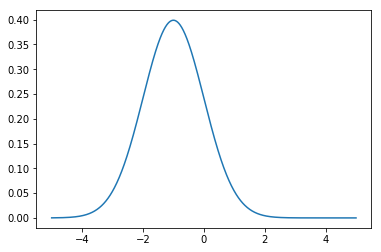

In [2]:
# target distribution

mu,sigma=-1,1
xs=np.linspace(-5,5,1000)
plt.plot(xs, norm.pdf(xs,loc=mu,scale=sigma))


The horizontal axis represents the domain of $x$. The generator network will map random values to this domain. 

Our discriminator and generator networks will be MLP:

In [3]:
TRAIN_ITERS=100000
M=200 # minibatch size

def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [4]:
# re-used for optimizing all networks
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,               # Base learning rate.
        batch,               # Current index into the dataset.
        TRAIN_ITERS // 4,    # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,
                                                                     global_step=batch,
                                                                     var_list=var_list)
    return optimizer

Pre-train discriminator

Text(0.5,1,'Initial Decision Boundary')

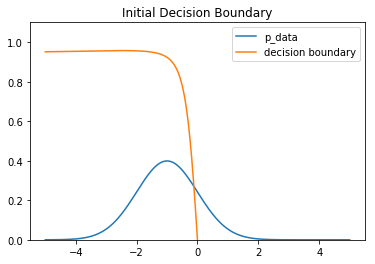

In [5]:
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(M,1))
    train_labels=tf.placeholder(tf.float32,shape=(M,1))
    D,theta=mlp(input_node,1)
    loss=tf.reduce_mean(tf.square(D-train_labels))
    
optimizer=momentum_optimizer(loss,None)

sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

# plot decision surface
def plot_d0(D,input_node):
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
    # decision boundary
    r=1000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    
    # process multiple points in parallel in a minibatch
    for i in range(int(r/M)):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D,{input_node: x})
    
    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0,1.1)
    plt.legend()
    
plot_d0(D,input_node)
plt.title('Initial Decision Boundary')

In [6]:
lh=np.zeros(1000)
for i in range(1000):
    d=(np.random.random(M)-0.5) * 10.0 
    labels=norm.pdf(d,loc=mu,scale=sigma)
    lh[i],_=sess.run([loss,optimizer], 
                     {input_node: np.reshape(d,(M,1)), 
                      train_labels: np.reshape(labels,(M,1))})

Text(0.5,1,'Training Loss')

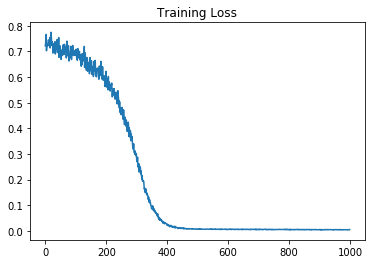

In [7]:
# training loss
plt.plot(lh)
plt.title('Training Loss')

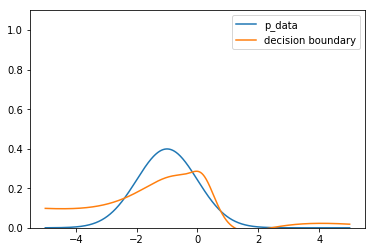

In [8]:
plot_d0(D,input_node)

In [9]:
# copy the learned weights over into a tmp array
weightsD=sess.run(theta)

# close the pre-training session
sess.close()

Now to build the actual generative adversarial network


In [10]:
with tf.variable_scope("G"):
    z_node=tf.placeholder(tf.float32, shape=(M,1)) # M uniform01 floats
    G,theta_g=mlp(z_node,1) # generate normal transformation of Z
    G=tf.multiply(5.0,G) # scale up by 5 to match range

with tf.variable_scope("D") as scope:
    # D(x)
    x_node=tf.placeholder(tf.float32, shape=(M,1)) # input M normally distributed floats
    fc,theta_d=mlp(x_node,1) # output likelihood of being normally distributed
    D1=tf.maximum(tf.minimum(fc,.99), 0.01) # clamp as a probability
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()
    fc,theta_d=mlp(G,1)
    D2=tf.maximum(tf.minimum(fc,.99), 0.01)

obj_d=tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g=tf.reduce_mean(tf.log(D2))

# set up optimizer for G,D
opt_d=momentum_optimizer(1-obj_d, theta_d)
opt_g=momentum_optimizer(1-obj_g, theta_g) # maximize log(D(G(z)))

In [11]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [12]:
# copy weights from pre-training over to new D network
for i,v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))


Text(0.5,1,'Before Training')

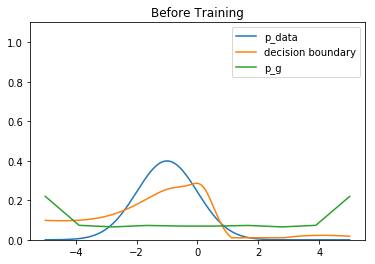

In [13]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=5000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(int(r/M)):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D1,{x_node: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(int(r/M)):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=sess.run(G,{z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()
    
# initial conditions
plot_fig()
plt.title('Before Training')

In [14]:
# Algorithm 1 of Goodfellow et al 2014
k=1
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x= np.random.normal(mu,sigma,M) # sampled m-batch from p_data
        x.sort()
        z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01  # sample m-batch from noise prior
        histd[i],_=sess.run([obj_d,opt_d], 
                            {x_node: np.reshape(x,(M,1)), 
                             z_node: np.reshape(z,(M,1))})
    z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01 # sample noise prior
    histg[i],_=sess.run([obj_g,opt_g], 
                        {z_node: np.reshape(z,(M,1))}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


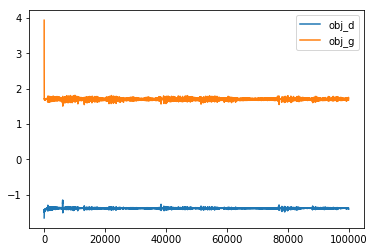

In [15]:
plt.plot(range(TRAIN_ITERS),histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()

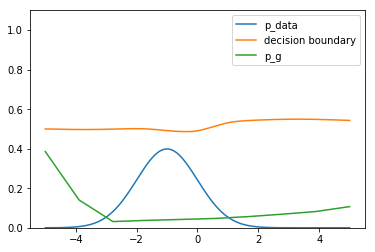

In [16]:
plot_fig()

### DGAN Architecture

Most GANs today are at least loosely based on the DCGAN architecture (Radford
et al., 2015). DCGAN stands for “deep, convolution GAN.”

Some of the key insights of the DCGAN architecture were to:

+ Use batch normalization layers in most layers
of both the discriminator and the generator, with the two minibatches for
the discriminator normalized separately. 

+ The overall network structure is mostly borrowed from the all-convolutional
net. 

+ The use of the Adam optimizer rather than SGD with momentum. 

<center>
<img src="images/dgan.png" alt="" style="width: 700px;"/> 
(Source: https://arxiv.org/pdf/1511.06434.pdf)
</center>


Generated bedrooms after one training pass through the dataset: 


<center>
<img src="images/dgan2.png" alt="" style="width: 700px;"/> 
(Source: https://github.com/Newmu/dcgan_code)
</center>


Covers: 

<center>
<img src="images/dgan3.png" alt="" style="width: 700px;"/> 
(Source: https://github.com/Newmu/dcgan_code)
</center>



https://www.youtube.com/watch?time_continue=3&v=XOxxPcy5Gr4